
<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:100px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 50px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Bank Churn Classification</span></b>
    </div>
    </div>
        


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">About the Dataset</span></b>
    </div>
    </div>
        

 <font size=5>Bank Customer Churn Dataset</font>

The **Bank Customer Churn dataset** is commonly used for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be customers. The dataset includes the following attributes:

- **Customer ID:** A unique identifier for each customer
- **Surname:** The customer's surname or last name
- **Credit Score:** A numerical value representing the customer's credit score
- **Geography:** The country where the customer resides (France, Spain, or Germany)
- **Gender:** The customer's gender (Male or Female)
- **Age:** The customer's age
- **Tenure:** The number of years the customer has been with the bank
- **Balance:** The customer's account balance
- **NumOfProducts:** The number of bank products the customer uses (e.g., savings account, credit card)
- **HasCrCard:** Whether the customer has a credit card (1 = yes, 0 = no)
- **IsActiveMember:** Whether the customer is an active member (1 = yes, 0 = no)
- **EstimatedSalary:** The estimated salary of the customer
- **Exited:** Whether the customer has churned (1 = yes, 0 = no)


The objective of the data is to identify which of these users have been churned (indicated by exited=1) based on the data given


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Imports and Reading Data</span></b>
    </div>
    </div>
        

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
import logging
from sklearn.preprocessing import LabelEncoder,StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import cross_validate,KFold,train_test_split,StratifiedKFold
from sklearn.metrics import log_loss,f1_score,roc_auc_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from prettytable import PrettyTable
import time

pd.set_option('display.max_columns',100)
%matplotlib inline
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(logging.CRITICAL + 1)

In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=FutureWarning, module="lightgbm")

In [3]:
#Reading the data 
train = pd.read_csv("bank_real.csv")
real = pd.read_csv("bank_train.csv")

In [4]:
#Removing unnecesary columns
train.drop(columns=['RowNumber'],inplace=True)
real.drop(columns=['id'],inplace=True)

In [5]:
#joining the training datasets
train = pd.concat([train,real]).reset_index(drop=True)


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Data Cleaning</span></b>
    </div>
    </div>
        

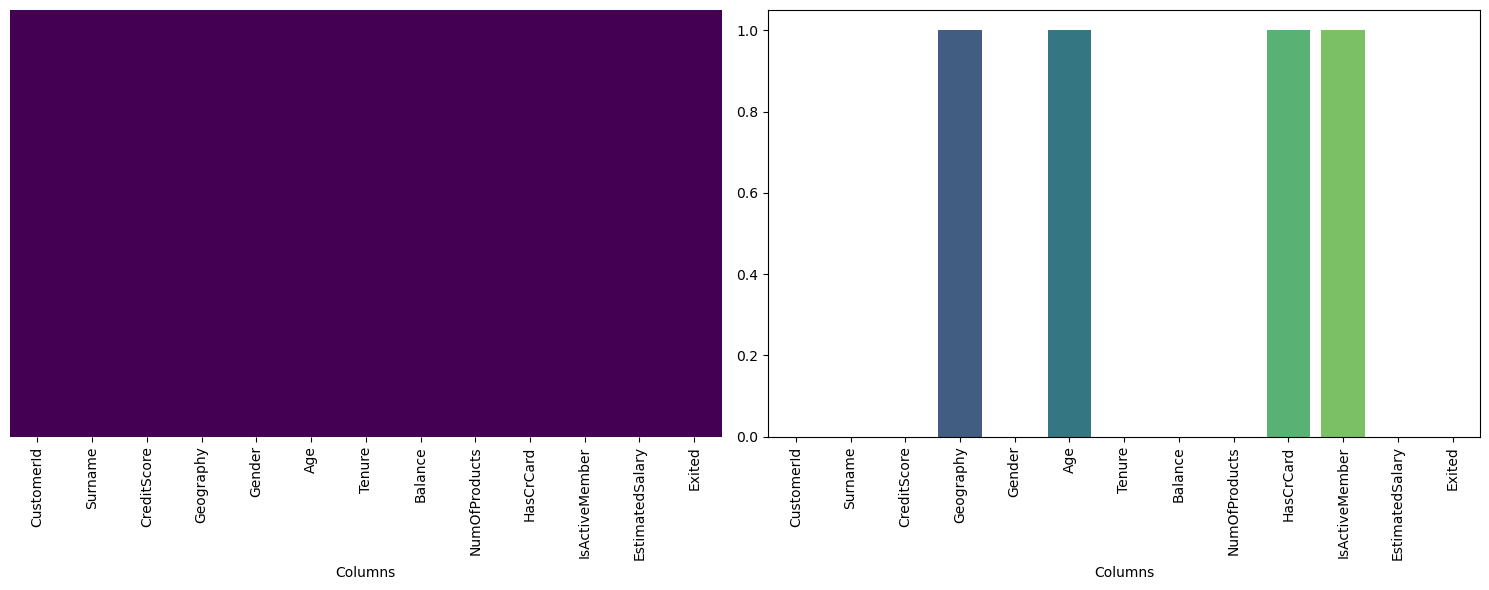

In [6]:
#looking for null values
def NullValues(df):
    '''
    This function looks for the null values in a data frame and return a heatmap indicating the null values and a barplot showing the number of missing values
    '''
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
    sns.heatmap(data=df.isnull(),yticklabels=False,ax=axes[0],cbar=False,cmap='viridis')
    sns.barplot(x=df.columns,y=df.isnull().sum(),ax=axes[1],palette='viridis')
    axes[1].set_xticklabels(labels= axes[1].get_xticklabels(), rotation=90)
    axes[1].set_xlabel("Columns")
    axes[0].set_xlabel("Columns")
    plt.tight_layout()
    plt.show()
    
NullValues(train)

In the training set there are 4 missing values. As the number of missing values are less we will just drop them instead of imputing them

In [7]:
#dropping the null values
train.dropna(inplace=True)

In [8]:
#Checking for duplicates
train[train.duplicated()]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10001,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


Two records are duplicate we will drop them 

In [9]:
#Removing the duplicate values
train.drop_duplicates(inplace=True)


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Exploratory Data Analysis</span></b>
    </div>
    </div>
        

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175030 entries, 0 to 175035
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       175030 non-null  int64  
 1   Surname          175030 non-null  object 
 2   CreditScore      175030 non-null  int64  
 3   Geography        175030 non-null  object 
 4   Gender           175030 non-null  object 
 5   Age              175030 non-null  float64
 6   Tenure           175030 non-null  int64  
 7   Balance          175030 non-null  float64
 8   NumOfProducts    175030 non-null  int64  
 9   HasCrCard        175030 non-null  float64
 10  IsActiveMember   175030 non-null  float64
 11  EstimatedSalary  175030 non-null  float64
 12  Exited           175030 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 18.7+ MB


In [11]:
train.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.750300e+05,175030.000000,175030.000000,175030.000000,175030.000000,175030.000000,175030.000000,175030.000000,175030.000000,175030.000000
mean,1.569194e+07,656.114506,38.171301,5.019951,56677.296954,1.553071,0.751186,0.498749,111862.765702,0.211152
std,7.142844e+04,81.148932,8.969551,2.811144,62982.318837,0.549211,0.432327,0.500000,50815.153467,0.408127
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563288e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,73225.310000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,116969.730000,0.000000
75%,1.575666e+07,710.000000,42.000000,7.000000,120727.970000,2.000000,1.000000,1.000000,154767.340000,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [12]:
#Give us the number of unique values for each column of data 
value_count_table = PrettyTable()
value_count_table.field_names = ['Column','Number of unique values','Type of column']
for col in train:
    n = train[col].nunique()
    if n <= 20:
        col_type = 'categorical'
    else:
        if train[col].dtype == 'O':
            col_type = 'String Column'
        else:
            col_type ='numerical'
        
    value_count_table.add_row([col,n,col_type])
    
print(value_count_table)

+-----------------+-------------------------+----------------+
|      Column     | Number of unique values | Type of column |
+-----------------+-------------------------+----------------+
|    CustomerId   |          23421          |   numerical    |
|     Surname     |           2932          | String Column  |
|   CreditScore   |           460           |   numerical    |
|    Geography    |            3            |  categorical   |
|      Gender     |            2            |  categorical   |
|       Age       |            73           |   numerical    |
|      Tenure     |            11           |  categorical   |
|     Balance     |          30239          |   numerical    |
|  NumOfProducts  |            4            |  categorical   |
|    HasCrCard    |            2            |  categorical   |
|  IsActiveMember |            2            |  categorical   |
| EstimatedSalary |          55581          |   numerical    |
|      Exited     |            2            |  categori

In [13]:
#Dividing all the features into categories
cat_cols = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember']
numeric_cols = ['CustomerId','CreditScore','Age','Balance','EstimatedSalary']
target = 'Exited'
high_cardinality_string = 'Surname'
original_col = train.columns

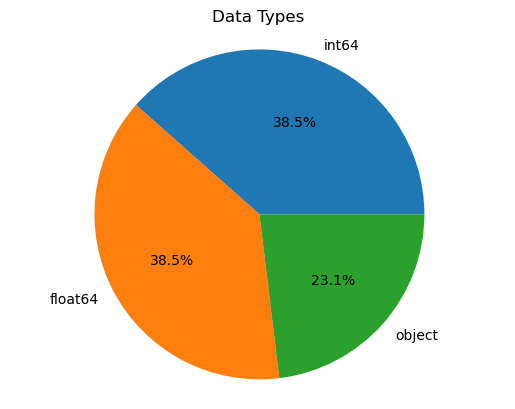

In [14]:
#looking at the data types present in the data
def GetDataType(df):
    plt.pie(df.dtypes.value_counts().values,labels=df.dtypes.value_counts().index,autopct='%1.1f%%')
    plt.title("Data Types")
    plt.axis('equal')
    plt.show()
    
GetDataType(train)


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:40px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 20px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Exploring Categorical Data</span></b>
    </div>
    </div>
        

In [15]:
def Categorical(df,cat_cols,n_cols=3):
    number_cols = len(df[cat_cols].columns)
    if(number_cols % n_cols == 0):
        n_rows=int(number_cols/n_cols)
    else:
        n_rows = number_cols//n_cols +1
    fig,axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(4*n_cols,4*n_rows))
    axes= axes.flatten()
      
    for i, col in enumerate(cat_cols):
        values = df[col].value_counts()
        axes[i].pie(values,labels=values.index,autopct="%0.1f%%",shadow=True,textprops={'size':15,'color':'black'},
                    explode = [0.05] * len(df[col].unique()))
        axes[i].set_aspect = 'equal'
        axes[i].set_title(f'Distribution of {col}')
        
    plt.tight_layout()
    plt.show()
    

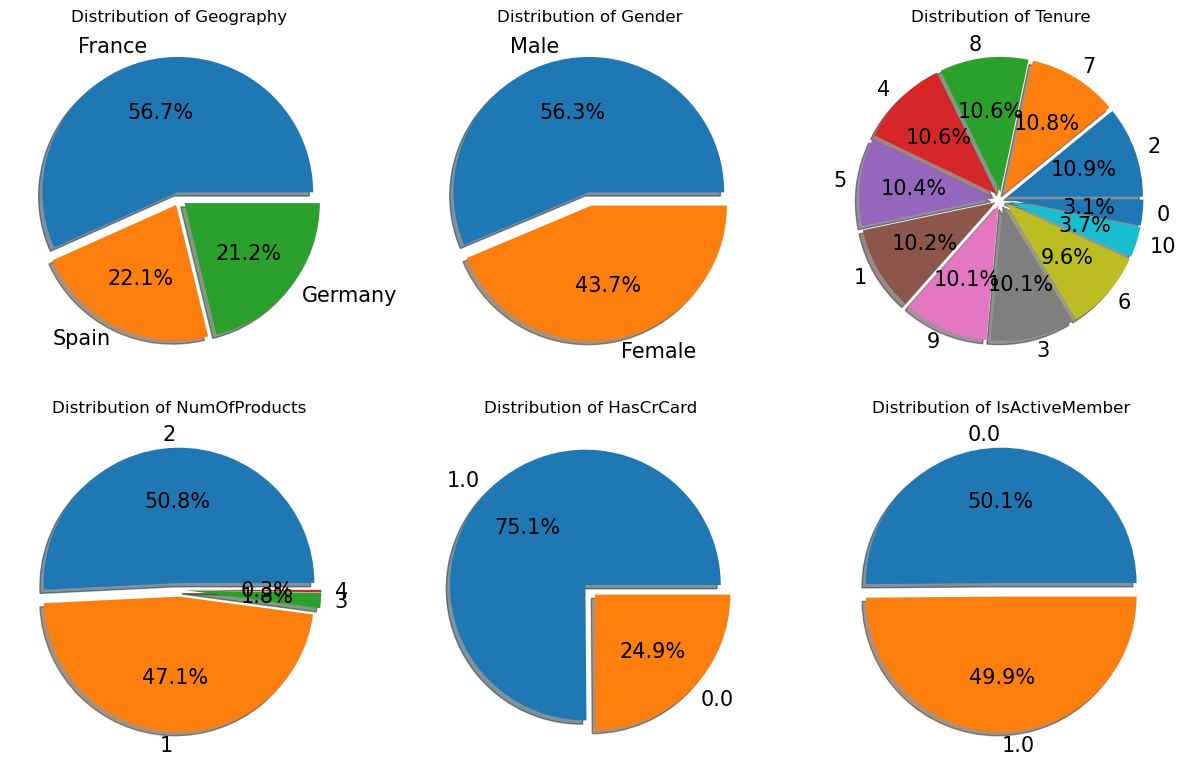

In [16]:
Categorical(train,cat_cols)

In [17]:
def ContingencyTables(df,col):
    for col in col:
        contingency_table = pd.crosstab(df[col],df[target],normalize='index')
        contingency_table.plot(kind='bar',stacked=True,figsize=(15,4))
        plt.title(f"Percentage Distribution of Target across {col}")
        plt.xlabel(col)
        plt.ylabel("Percentage")
        plt.legend(title="Churn Class")
        plt.show()

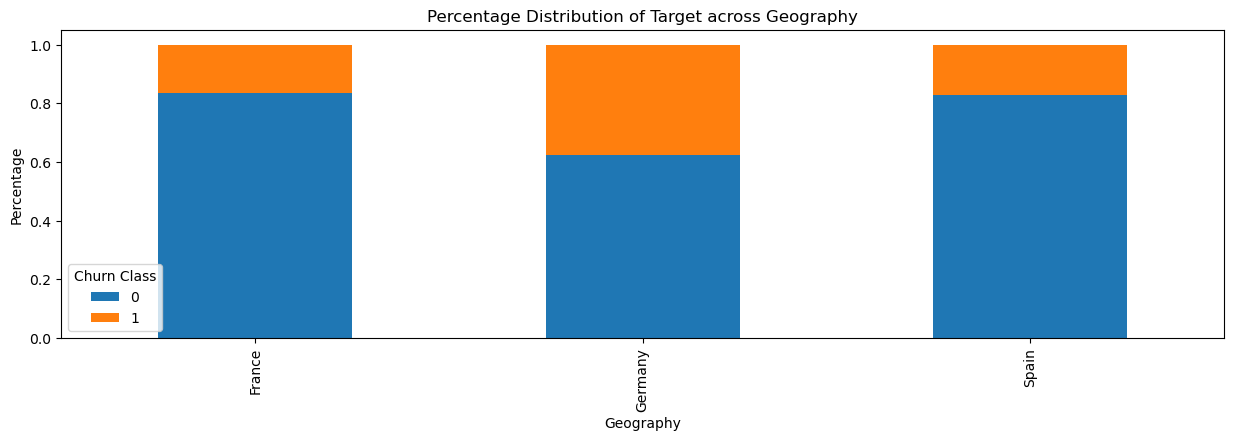

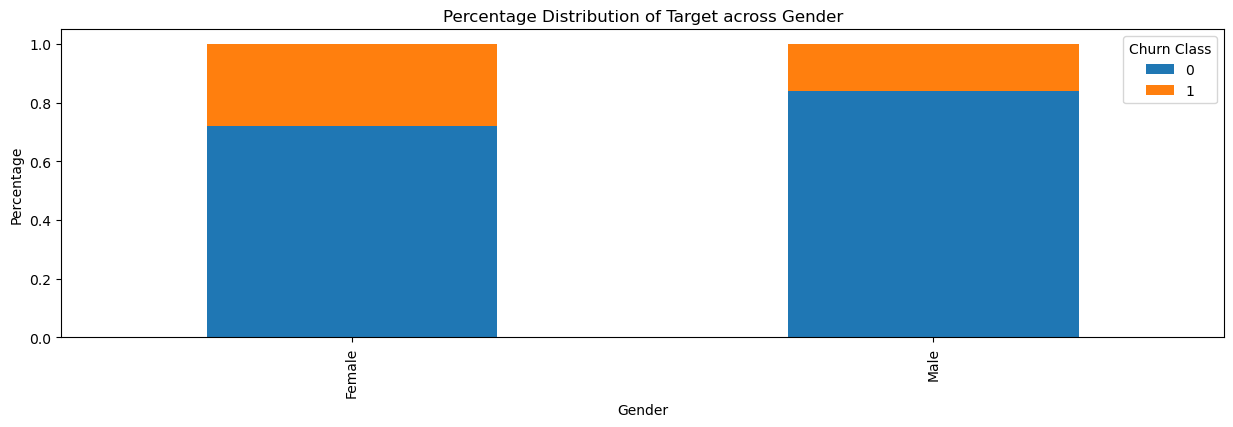

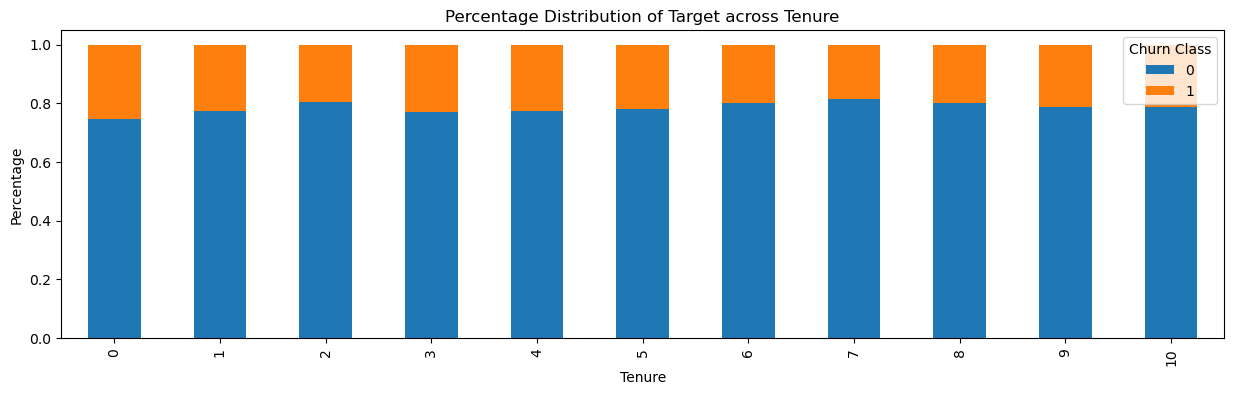

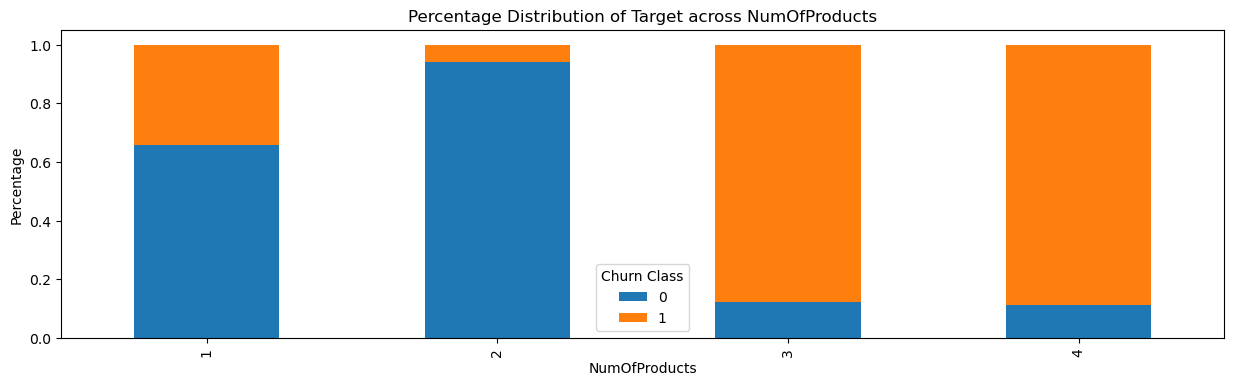

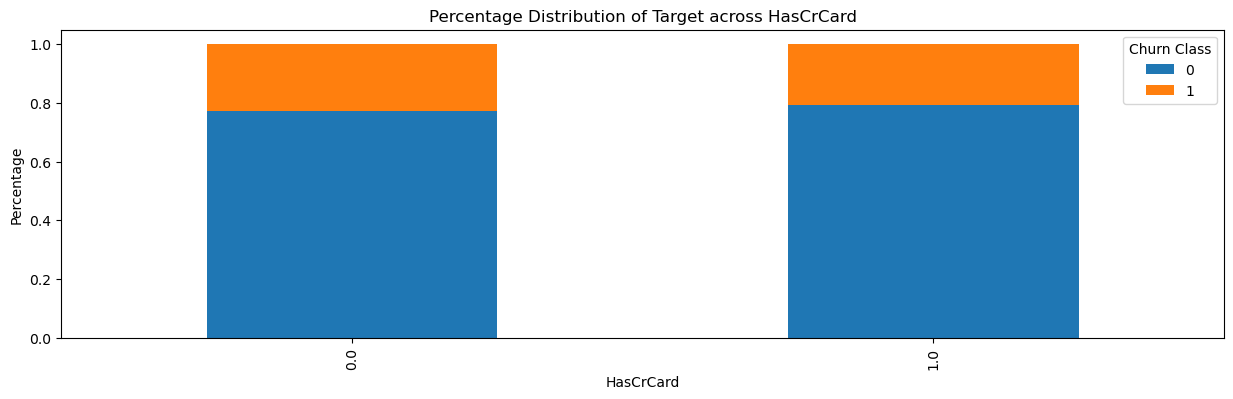

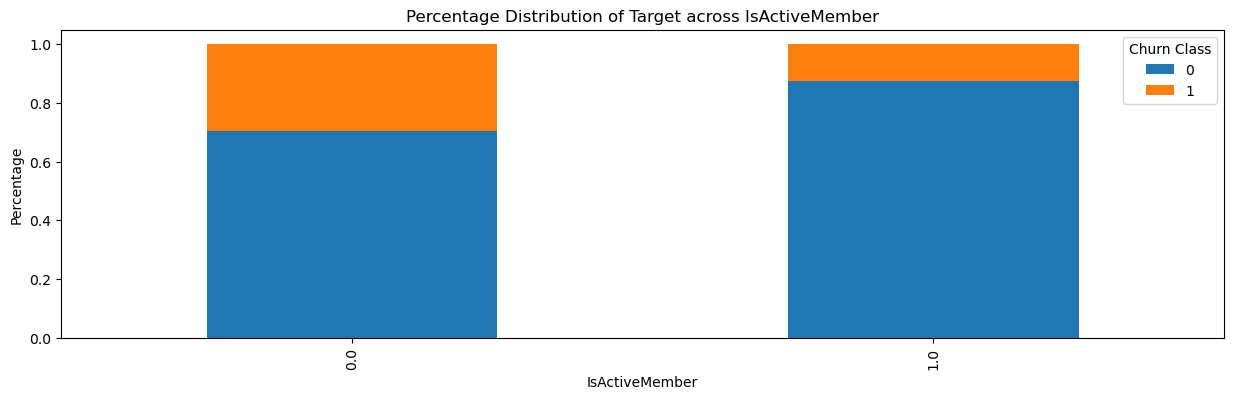

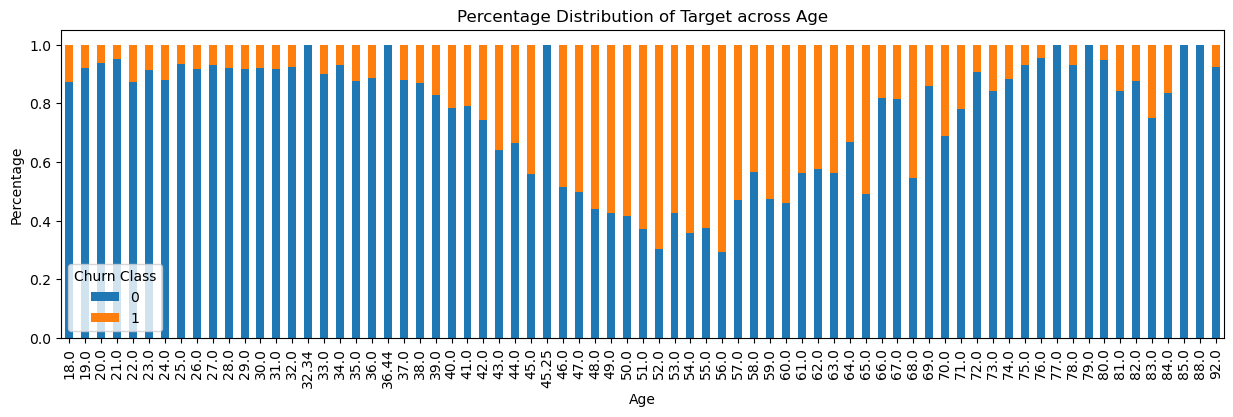

In [18]:
ContingencyTables(train,cat_cols+['Age'])

Contingency table tells us the probabilty that a category will be churned(1) 
- The age range 35-70 are churning more than other ages
- Members that are not active are more likely to churn
- People who have 3 or 4 products are more likely to churn 
- Females are churning more then males
- People from Germany are churning more than the other countries
- Cr card and tenure do not give much insight 

This information can be used to make new features


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:40px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 20px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Exploring the continuous numeric data</span></b>
    </div>
    </div>
        

In [19]:
def violin_plot(train_df,n_cols=3):
    number_cols = len(train_df.columns)
    if(number_cols % n_cols == 0):
        n_rows=int(number_cols/n_cols)
    else:
        n_rows = number_cols//n_cols +1
    fig,axs = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(4*n_cols,4*n_rows))
    axs= axs.flatten()
    
    for i, col in enumerate(numeric_cols):
        sns.violinplot(x=target, y=col, data=train, ax=axs[i])
        axs[i].set_title(f'{col.title()} Violin Plot', fontsize=14)
        axs[i].set_xlabel('Churn', fontsize=12)
        axs[i].set_ylabel(col.title(), fontsize=12)
        sns.despine()
        
        
    plt.tight_layout()
    plt.show()

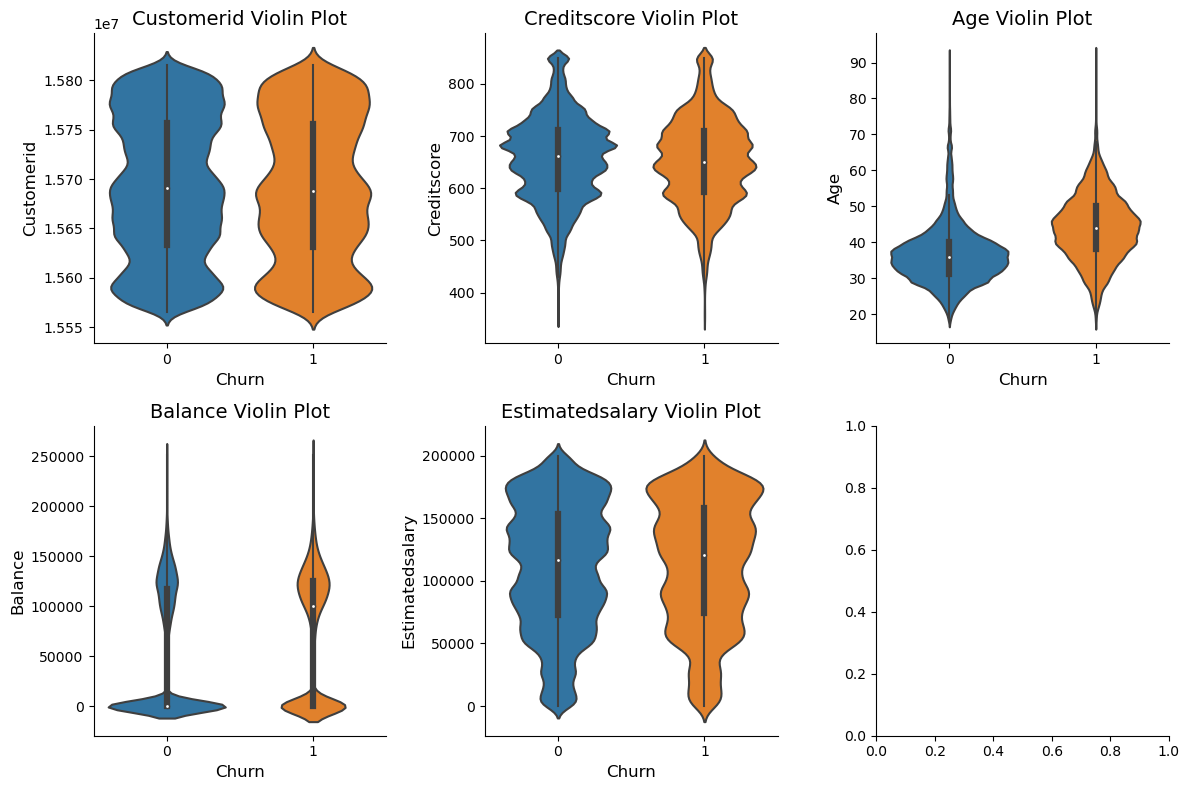

In [20]:
violin_plot(train[numeric_cols])

The violin plot tells gives the distribution and statistical info like mean,median and quartiles
- Age distribution is differnet for customers who got churned. The age of customers who got churned is slightly higher
- People with zero balance are more likely to not churn and people with balance between 100k and 150k are more likely to churn 


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Feature Engineering</span></b>
    </div>
    </div>
        

In [21]:
#OneHotEncoding the Geography column
train[['France','Germany','Spain']]  = pd.get_dummies(train['Geography']).astype('int64')

In [22]:
train.drop(columns=['Geography'],inplace=True)

In [23]:
#Label encoding the gender
label_encoder = LabelEncoder()
label_cols = ['Gender']
for i in label_cols:
    train[i]  = label_encoder.fit_transform(train[i])

In [25]:
#OneHotEncoding the NumOfProducts
train[['OneProduct','TwoProducts','ThreeProducts','FourProducts']] = pd.get_dummies(train['NumOfProducts']).astype('int64')

In [26]:
#Splitting the age feature into 3 groups. Based of the EDA people from 35-70 have a higher chance to churn 
train['Age(30-70)'] = train['Age'].apply(lambda x: 1 if x<=70 and x>=35 else 0)

train['Age(less30)'] = train['Age'].apply(lambda x: 1 if x<30 else 0)

train['Age(greater70)'] = train['Age'].apply(lambda x: 1 if x>70 else 0)                                     

In [27]:
#Adding a risk factor. Males and people from Germany have a higher chance to churn 
train['Risk'] = np.where((train['Age(30-70)'] == 1) & (train['Germany'] == 1) & (train['Gender'] == 1), 1,0)

In [28]:
#Based on balance EDA people with zero balance are less likely to churn and people with balance 100k - 150k have higher chance to churn 
train['ZeroBalance'] = train['Balance'].apply(lambda x : 1 if x == 0 else 0)
train['Balance(100-150k)'] = train['Balance'].apply(lambda x : 1 if x >= 10000 and x<=150000 else 0)

In [29]:
new_features = [x for x in train.columns.to_list() if x not in original_col]

Looking at the new features

In [30]:
train[new_features].head()

,France,Germany,Spain,OneProduct,TwoProducts,ThreeProducts,FourProducts,Age(30-70),Age(less30),Age(greater70),Risk,ZeroBalance,Balance(100-150k)
0,1,0,0,1,0,0,0,1,0,0,0,1,0
1,0,0,1,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,1,0,1,0,0,0,0,0
3,1,0,0,0,1,0,0,1,0,0,0,1,0
5,0,0,1,0,1,0,0,1,0,0,0,0,1



<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Feature Selection</span></b>
    </div>
    </div>
        

In [31]:
#All the columns 
train.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'France', 'Germany', 'Spain', 'OneProduct',
       'TwoProducts', 'ThreeProducts', 'FourProducts', 'Age(30-70)',
       'Age(less30)', 'Age(greater70)', 'Risk', 'ZeroBalance',
       'Balance(100-150k)'],
      dtype='object')

We wil not use the CustomerId and Surname columns

In [32]:
final_cols = [ 'CreditScore', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'France', 'Germany', 'Spain', 'OneProduct',
       'TwoProducts', 'ThreeProducts', 'FourProducts', 'Age(30-70)',
       'Age(less30)', 'Age(greater70)', 'Risk', 'ZeroBalance',
       'Balance(100-150k)']

In [33]:
def CorrelationFeatures(df,title=""):
    '''
    Function to get correlation heat map
    '''
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(16,16))
    sns.heatmap(data=df.astype(float).corr(),linecolor='white',linewidths=0.1,annot=True,annot_kws={'size':8,'color':'black','weight':'bold'},cmap='viridis',
                vmin=-1.0,vmax=1.0,square=True,mask=mask)
    plt.title(f"Correlation of {title} features")
    plt.show()

In [34]:
y = train['Exited']

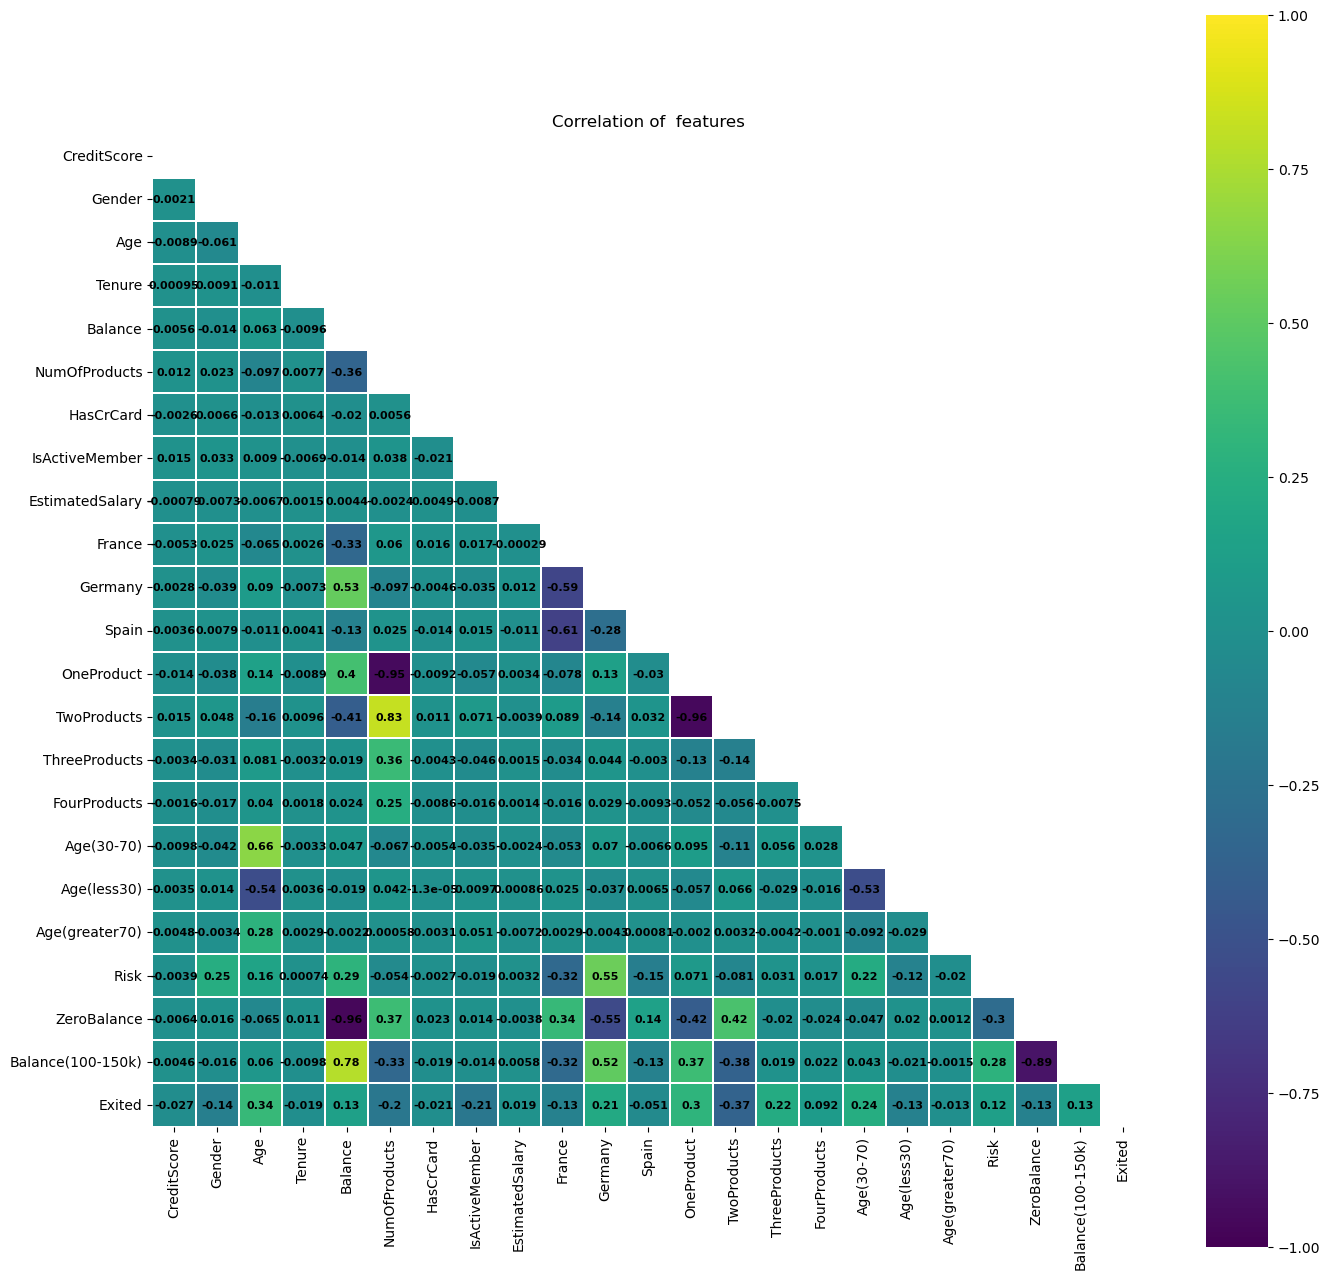

In [35]:
CorrelationFeatures(train[final_cols + ['Exited']])

We should remove highly correlated features but in this case there is not much correlation so we can proceed


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Scaling the Data</span></b>
    </div>
    </div>
        

In [37]:
#Scaling the data 
def ScaleData(train):
    scaler = StandardScaler()

    X = scaler.fit_transform(train)
    X = pd.DataFrame(X)
    X.columns = train.columns
    
    
    return X 

In [39]:
X = ScaleData(train[final_cols])


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Splitting Data into training and validation</span></b>
    </div>
    </div>
        

We will split the data into 2 parts. One part will be used to train the data, that part will be trained with cross validation. The second part will be used to only evaluate the model /

In [47]:
X_train , X_test, y_train , y_test = train_test_split(X,y,test_size=0.2)

In [49]:
X_train.shape

(140024, 22)

In [50]:
y_train.shape

(140024,)

In [52]:
X_test.shape

(35006, 22)

In [54]:
y_test.shape

(35006,)


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Model Selection</span></b>
    </div>
    </div>
        

To select a model we will create a cross validation stratergy and then test the model on accuracy and roc_auc score

In [40]:
#Making a cross validation
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [55]:
def CrossValidate(clf,X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    scores = PrettyTable()
    scores.field_names = ['Fold','Accuracy','Roc_auc','Confusion Matrix','time to train']
    conf_matrices = []
    accuracies = []
    roc_auc_scores = []
    training_times = []
    for  train_index, test_index in kf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        start = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        conf_matrices.append(confusion_matrix(y_test, y_pred))
        accuracies.append(round(accuracy_score(y_test, y_pred),5))
        roc_auc_scores.append(round(roc_auc_score(y_test, y_prob),5))
        end = time.time()
        training_times.append(round(end-start,2))

    for i in range(10):
        scores.add_row([(i+1),accuracies[i],roc_auc_scores[i],conf_matrices[i],training_times[i]])

    print(scores)
    print(f"Mean accuracy - {sum(accuracies) / 10}")
    print(f"Mean roc_auc - {sum(roc_auc_scores) / 10}") 
    
    return accuracies , roc_auc_scores
    

In [56]:
def FeatureImp(model):
    fi = model.feature_importances_
    sorted_idx = np.argsort(fi).tolist()
    plt.figure(figsize=(8,8))
    plt.barh(range(len(sorted_idx)), fi[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [final_cols[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:40px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 20px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Light Gradient Boosting</span></b>
    </div>
    </div>
        

In [57]:
#Using optuna we got these hyper parameters
lgbm_best_params = {'num_leaves': 52,
 'learning_rate': 0.07895324521843525,
 'feature_fraction': 0.5658166490064884,
 'bagging_fraction': 0.4307596104050439,
 'reg_alpha': 0.0740870606923929,
 'reg_lambda': 2.6993567325444864e-06,
 'min_child_samples': 10,
                   'verbose':-1}

In [58]:
lgbm = LGBMClassifier(**lgbm_best_params)

In [61]:
lgbm_accuracy , lgbm_roc_auc = CrossValidate(lgbm,X_train,y_train)

+------+----------+---------+------------------+---------------+
| Fold | Accuracy | Roc_auc | Confusion Matrix | time to train |
+------+----------+---------+------------------+---------------+
|  1   | 0.86353  |  0.8863 |  [[10437   613]  |      1.03     |
|      |          |         |  [ 1298  1655]]  |               |
|  2   | 0.86831  | 0.88803 |  [[10529   521]  |      0.64     |
|      |          |         |  [ 1323  1630]]  |               |
|  3   | 0.86396  | 0.88934 |  [[10482   568]  |      0.62     |
|      |          |         |  [ 1337  1616]]  |               |
|  4   | 0.86846  | 0.89162 |  [[10521   529]  |      0.64     |
|      |          |         |  [ 1313  1640]]  |               |
|  5   | 0.86052  |  0.8853 |  [[10440   610]  |      0.62     |
|      |          |         |  [ 1343  1609]]  |               |
|  6   | 0.86423  | 0.88854 |  [[10484   566]  |      0.63     |
|      |          |         |  [ 1335  1617]]  |               |
|  7   | 0.86759  |  0.89

In [63]:
lgbm.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.4307596104050439,
               feature_fraction=0.5658166490064884,
               learning_rate=0.07895324521843525, min_child_samples=10,
               num_leaves=52, reg_alpha=0.0740870606923929,
               reg_lambda=2.6993567325444864e-06, verbose=-1)

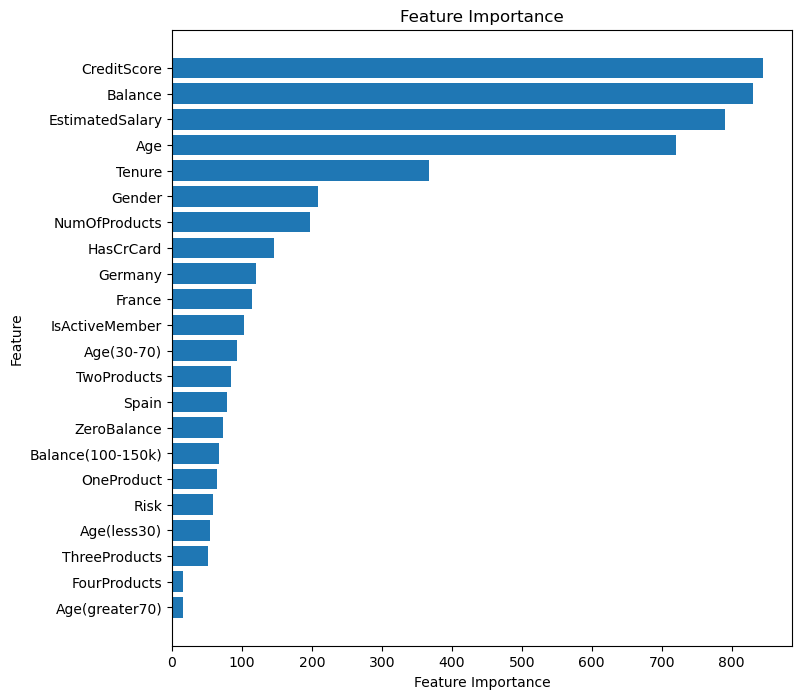

In [64]:
FeatureImp(lgbm)


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:40px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 20px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">XG Boost Model</span></b>
    </div>
    </div>
        

In [65]:
#Parameters obtained from optuna
xg_best_params = {'lambda': 0.40093945695899574,
 'alpha': 0.003367228970383607,
 'subsample': 0.9015674829231023,
 'colsample_bytree': 0.432988538034984,
 'learning_rate': 0.04678656681603368,
 'n_estimators': 478,
 'max_depth': 6,
 'min_child_weight': 6,
 'gamma': 0.00021168183130911497}

In [66]:
xg = XGBClassifier(**xg_best_params)

In [67]:
xg_accuracy , xg_roc_auc = CrossValidate(xg,X_train,y_train)

+------+----------+---------+------------------+---------------+
| Fold | Accuracy | Roc_auc | Confusion Matrix | time to train |
+------+----------+---------+------------------+---------------+
|  1   | 0.86367  | 0.88685 |  [[10451   599]  |     11.86     |
|      |          |         |  [ 1310  1643]]  |               |
|  2   | 0.86774  | 0.88962 |  [[10535   515]  |     11.12     |
|      |          |         |  [ 1337  1616]]  |               |
|  3   | 0.86496  | 0.89176 |  [[10484   566]  |     11.04     |
|      |          |         |  [ 1325  1628]]  |               |
|  4   | 0.86996  | 0.89272 |  [[10536   514]  |     11.33     |
|      |          |         |  [ 1307  1646]]  |               |
|  5   | 0.86023  | 0.88611 |  [[10444   606]  |     11.42     |
|      |          |         |  [ 1351  1601]]  |               |
|  6   | 0.86402  | 0.89043 |  [[10484   566]  |     12.05     |
|      |          |         |  [ 1338  1614]]  |               |
|  7   | 0.86866  | 0.892

In [68]:
xg.fit(X_train,y_train)

XGBClassifier(alpha=0.003367228970383607, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.432988538034984, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00021168183130911497, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.40093945695899574, learning_rate=0.04678656681603368,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=478, n_jobs=None, num_parallel_tree=None, ...)

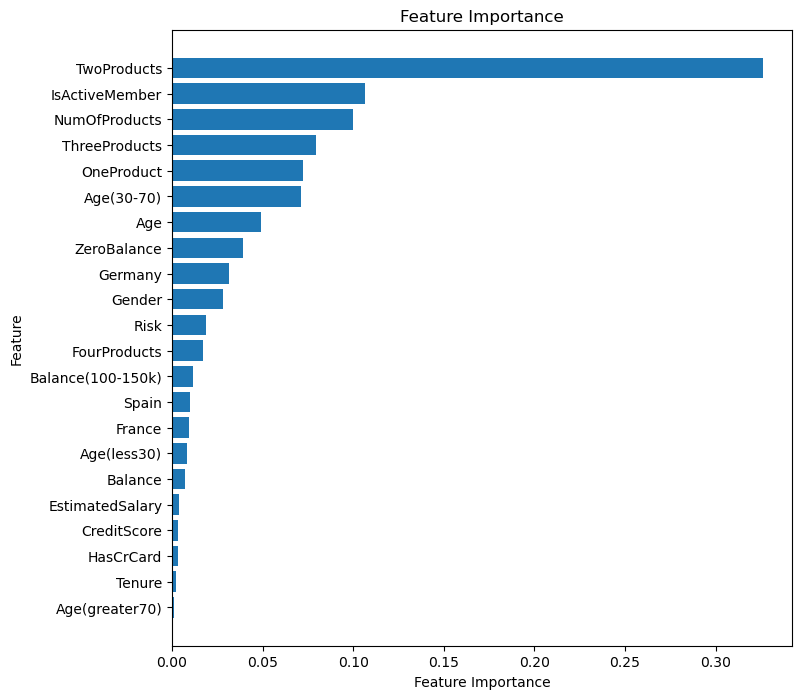

In [69]:
FeatureImp(xg)


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:40px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 20px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Cat Boost </span></b>
    </div>
    </div>
        

In [70]:
cat = CatBoostClassifier(verbose=0)

In [71]:
cat_accuracy, cat_roc_auc = CrossValidate(cat,X_train,y_train)

+------+----------+---------+------------------+---------------+
| Fold | Accuracy | Roc_auc | Confusion Matrix | time to train |
+------+----------+---------+------------------+---------------+
|  1   |  0.8631  | 0.88488 |  [[10459   591]  |     13.65     |
|      |          |         |  [ 1326  1627]]  |               |
|  2   |  0.8666  | 0.88789 |  [[10538   512]  |     13.33     |
|      |          |         |  [ 1356  1597]]  |               |
|  3   | 0.86403  | 0.88969 |  [[10478   572]  |     13.57     |
|      |          |         |  [ 1332  1621]]  |               |
|  4   | 0.86831  | 0.89169 |  [[10539   511]  |     13.32     |
|      |          |         |  [ 1333  1620]]  |               |
|  5   | 0.85966  | 0.88412 |  [[10453   597]  |     13.73     |
|      |          |         |  [ 1368  1584]]  |               |
|  6   | 0.86452  | 0.88774 |  [[10481   569]  |     13.52     |
|      |          |         |  [ 1328  1624]]  |               |
|  7   | 0.86716  | 0.890

In [72]:
cat.fit(X_train,y_train)

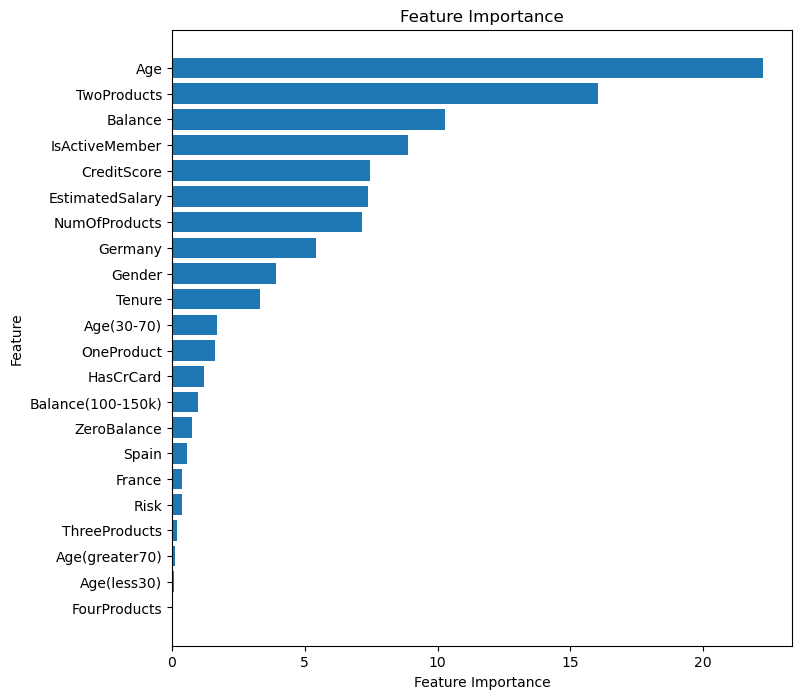

In [73]:
FeatureImp(cat)


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Model Ensemble Voitng Classifier</span></b>
    </div>
    </div>
        

Now to get the advantages of the 3 individual models we will use a voting ensemble which votes based on the probability of each models predictions

The Xg boost model performed the best so we will give it more weightage than the lgbm and cat model

In [80]:
voting = VotingClassifier(estimators=[('lgbm',lgbm),('xg',xg),('cat',cat)],voting='soft',weights=[1,2,1])

In [81]:
voting_accuracy, voting_roc_auc = CrossValidate(voting,X_train,y_train)

+------+----------+---------+------------------+---------------+
| Fold | Accuracy | Roc_auc | Confusion Matrix | time to train |
+------+----------+---------+------------------+---------------+
|  1   | 0.86317  | 0.88694 |  [[10446   604]  |     26.82     |
|      |          |         |  [ 1312  1641]]  |               |
|  2   | 0.86717  | 0.88951 |  [[10534   516]  |     26.32     |
|      |          |         |  [ 1344  1609]]  |               |
|  3   | 0.86539  | 0.89146 |  [[10488   562]  |     25.92     |
|      |          |         |  [ 1323  1630]]  |               |
|  4   | 0.86981  | 0.89294 |  [[10545   505]  |     26.59     |
|      |          |         |  [ 1318  1635]]  |               |
|  5   | 0.86052  | 0.88613 |  [[10455   595]  |     27.15     |
|      |          |         |  [ 1358  1594]]  |               |
|  6   | 0.86452  | 0.89007 |  [[10487   563]  |     26.73     |
|      |          |         |  [ 1334  1618]]  |               |
|  7   |  0.8683  | 0.892

In [82]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(bagging_fraction=0.4307596104050439,
                                             feature_fraction=0.5658166490064884,
                                             learning_rate=0.07895324521843525,
                                             min_child_samples=10,
                                             num_leaves=52,
                                             reg_alpha=0.0740870606923929,
                                             reg_lambda=2.6993567325444864e-06,
                                             verbose=-1)),
                             ('xg',
                              XGBClassifier(alpha=0.003367228970383607,
                                            base_score=None, booster=None,
                                            callb...
                                            learning_rate=0.04678656681603368,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=6,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=478, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x00000232CA6AB4C0>)],
                 voting='soft', weights=[1, 2, 1])


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Final Model Evaluation</span></b>
    </div>
    </div>
        


In [83]:
preds = voting.predict(X_test)
preds_proba = voting.predict_proba(X_test)[:,1]

In [86]:
accuracy = accuracy_score(y_test,preds)
roc_auc = roc_auc_score(y_test,preds_proba)

In [93]:
print(f"Accuracy - {accuracy} \nRoc-auc-score - {roc_auc}")

Accuracy - 0.867079929155002 
Roc-auc-score - 0.8904815717338129


In [95]:
confusion = confusion_matrix(y_test,preds)

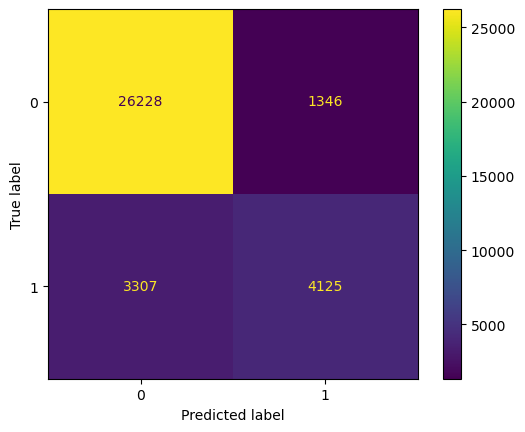

In [110]:
confusion_figure = ConfusionMatrixDisplay(confusion_matrix=confusion)
confusion_figure.plot()
plt.show()


<div style="border-left: 16px solid #EFF9F0; overflow: hidden; border-radius:10px; height:70px; width:100%; display:flex;">
    <div style="height: 100%; width: 100%; background-color: #13070C; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 40px; ">
            <b><span style="color: #EFF9F0;padding: 0px 20px">Future Improvements</span></b>
    </div>
    </div>
        

The final model has a accuracy of 86.7 and area under the curve of 0.89

Based on the confusion matrix the false negative value is high which has to be improved on. In bank churn false negatives are problematic

Ways to improve- 
- Get more data. Adding more data always helps improve the performance
- Add features that give more info of negative customers so that the false negative value decreases 
- Testing different models that might work better might help 
- Xg models work the best so we can focus more on that